

В датасете (_автор: Waqar Ali_) представлены данные о взаимодействии пользователей на платформе электронной торговли, который включает в себя последовательности событий, таких как просмотр страниц, клики, просмотр товаров и покупки. Каждая запись фиксирует действия пользователя в рамках сеансов, что делает её пригодной для анализа траекторий кликов и последовательностей транзакций.

Описание данных:
- `UserID` Уникальный идентификатор для каждого пользователя.
- `SessionID` Уникальный идентификатор для каждой сессии.
- `Timestamp` Дата и время взаимодействия.
- `EventType` Тип события (например, просмотр страницы, клик, просмотр товара, добавление в корзину, покупка).
- `ProductID` Уникальный идентификатор товаров, участвующих во взаимодействии.
- `Amount` Сумма транзакции (для покупок).
- `Outcome` Целевое событие (например, покупка).

In [16]:
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
    

In [2]:
# Чтение данных из файла в датафрейм
data = pd.read_csv('ecommerce_clickstream_transactions.csv')

print(data.head())

   UserID  SessionID                   Timestamp     EventType  ProductID  \
0       1          1  2024-07-07 18:00:26.959902     page_view        NaN   
1       1          1  2024-03-05 22:01:00.072000     page_view        NaN   
2       1          1  2024-03-23 22:08:10.568453  product_view  prod_8199   
3       1          1  2024-03-12 00:32:05.495638   add_to_cart  prod_4112   
4       1          1  2024-02-25 22:43:01.318876   add_to_cart  prod_3354   

   Amount Outcome  
0     NaN     NaN  
1     NaN     NaN  
2     NaN     NaN  
3     NaN     NaN  
4     NaN     NaN  


In [3]:
# Приведение к общепринятому виду названий столбцов
data = data.rename(columns={
    'UserID': 'user_id',
    'SessionID': 'session_id',
    'Timestamp': 'timestamp',
    'EventType': 'event_type',
    'ProductID': 'product_id',
    'Amount': 'amount',
    'Outcome': 'outcome'
})

In [4]:
# Проверка, что 'data' является копией DataFrame, чтобы избежать предупреждения SettingWithCopyWarning
data = data.copy()

In [5]:
# Отображение количества отсутствующих значений в каждом столбце
print("Пропущенные значения в каждом столбце:")
print(data.isnull().sum())

Пропущенные значения в каждом столбце:
user_id           0
session_id        0
timestamp         0
event_type        0
product_id    42704
amount        64135
outcome       64135
dtype: int64


In [6]:
# Удаление строк, в которых существенные столбцы имеют недостающие значения
data_cleaned = data.dropna(subset=['user_id', 'session_id', 'timestamp', 'event_type'])

# В качестве альтернативы можно заполнить недостающие значения определенными величинами или использовать интерполяцию
# Для числовых столбцов можно использовать data['amount'].fillna(data['amount'].median(), inplace=True)
# Для категориальных столбцов можно использовать data['product_id'].fillna('Unknown', inplace=True)

print("Обработка пропущенных значений. Очищенный набор данных:")
print(data_cleaned.isnull().sum())

Обработка пропущенных значений. Очищенный набор данных:
user_id           0
session_id        0
timestamp         0
event_type        0
product_id    42704
amount        64135
outcome       64135
dtype: int64


In [7]:
# Преобразование временной метки в формат времени
data_cleaned['timestamp'] = pd.to_datetime(data_cleaned['timestamp'])

# Преобразование суммы в числовое значение
data_cleaned['amount'] = pd.to_numeric(data_cleaned['amount'], errors='coerce')

# Проверка, что product_id и outcome являются категориальными или объектными типами
data_cleaned['product_id'] = data_cleaned['product_id'].astype('category')
data_cleaned['outcome'] = data_cleaned['outcome'].astype('category')

# Отображение типов данных для подтверждения изменений
print("Типы данных после преобразования:")
print(data_cleaned.dtypes)

Типы данных после преобразования:
user_id                int64
session_id             int64
timestamp     datetime64[ns]
event_type            object
product_id          category
amount               float64
outcome             category
dtype: object


In [8]:
# Удаление строк с amount = 0, если они не нужны
data_filtered = data_cleaned[data_cleaned['amount'] > 0]

# Отображение формы отфильтрованного датафрейма
print("Форма отфильтрованного набора данных:")
print(data_filtered.shape)

Форма отфильтрованного набора данных:
(10682, 7)


In [9]:
# Замена бесконечных значений на NaN
data.replace([np.inf, -np.inf], np.nan, inplace=True)

# Заполнение недостающих значений
data['amount'] = data['amount'].fillna(0)  # Reassign the result
data['outcome'] = data['outcome'].fillna('Unknown')  # Reassign the result

# Преобразование 'Timestamp' в datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Извлечения даты
data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day_of_week'] = data['timestamp'].dt.dayofweek

# Создание нового столбца на основе EventType
data['is_purchase'] = data['event_type'].apply(lambda x: 1 if x == 'purchase' else 0)

# Вывод первых строк с новыми данными
print("Данные с новыми возможностями:")
print(data.head())

Данные с новыми возможностями:
   user_id  session_id                  timestamp    event_type product_id  \
0        1           1 2024-07-07 18:00:26.959902     page_view        NaN   
1        1           1 2024-03-05 22:01:00.072000     page_view        NaN   
2        1           1 2024-03-23 22:08:10.568453  product_view  prod_8199   
3        1           1 2024-03-12 00:32:05.495638   add_to_cart  prod_4112   
4        1           1 2024-02-25 22:43:01.318876   add_to_cart  prod_3354   

   amount  outcome  year  month  day_of_week  is_purchase  
0     0.0  Unknown  2024      7            6            0  
1     0.0  Unknown  2024      3            1            0  
2     0.0  Unknown  2024      3            5            0  
3     0.0  Unknown  2024      3            1            0  
4     0.0  Unknown  2024      2            6            0  


Проверка на наличие оставшихся бесконечных значений:
user_id        0
session_id     0
timestamp      0
event_type     0
product_id     0
amount         0
outcome        0
year           0
month          0
day_of_week    0
is_purchase    0
dtype: int64
Описательная статистика:
             user_id    session_id                      timestamp event_type  \
count   74817.000000  74817.000000                          74817      74817   
unique           NaN           NaN                            NaN          7   
top              NaN           NaN                            NaN  page_view   
freq             NaN           NaN                            NaN      10819   
mean      500.740741      5.509777  2024-04-12 21:17:37.800426240        NaN   
min         1.000000      1.000000     2024-01-01 00:01:35.004064        NaN   
25%       251.000000      3.000000  2024-02-21 04:42:25.190728960        NaN   
50%       501.000000      6.000000     2024-04-13 00:51:23.434848        NaN   
75

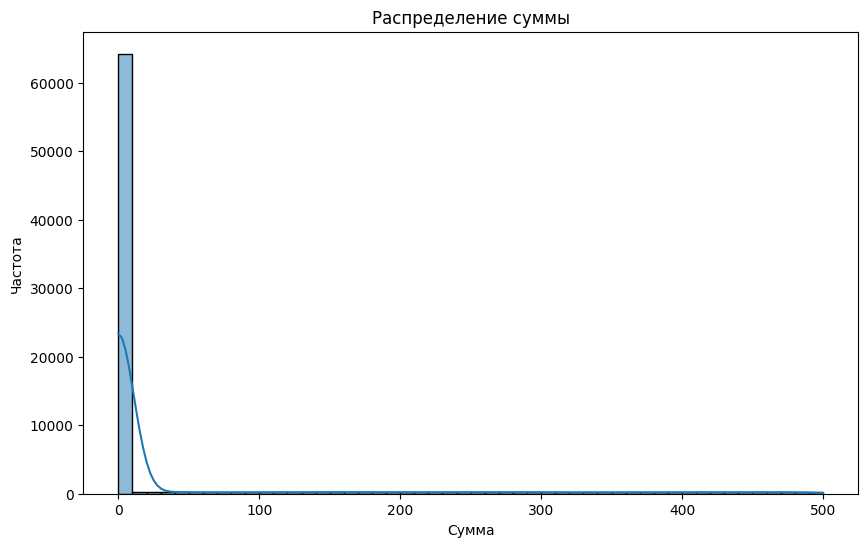

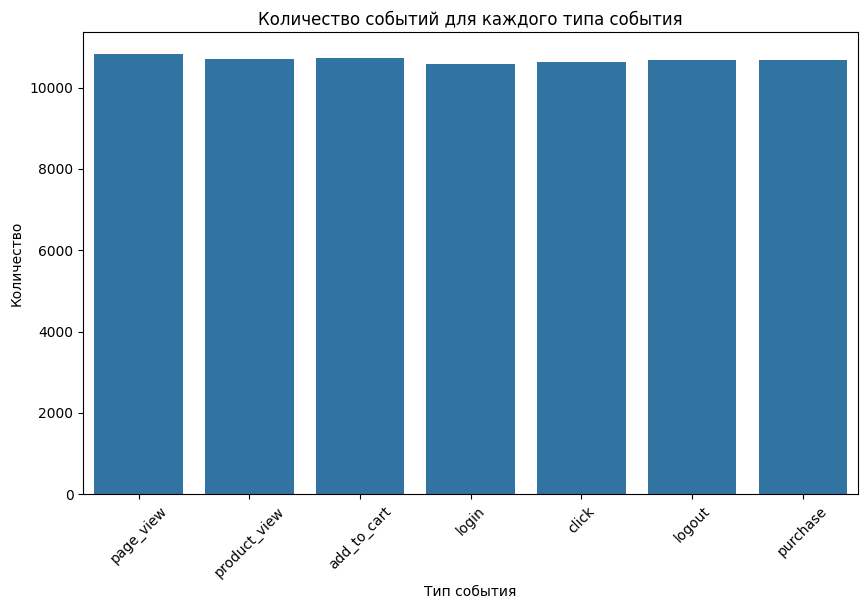

In [10]:
# Проверка, что 'data' - это DataFrame, и замена бесконечных значений на NaN
data = data.replace([np.inf, -np.inf], np.nan)

# Заполнение значения NaN соответствующими значениями
data['amount'] = data['amount'].fillna(0)

# Проверка, не осталось ли бесконечных значений
print("Проверка на наличие оставшихся бесконечных значений:")
print(data.isin([np.inf, -np.inf]).sum())

# Описательная статистика
print("Описательная статистика:")
print(data.describe(include='all'))

# График распределения суммы
plt.figure(figsize=(10, 6))
sns.histplot(data['amount'].dropna(), bins=50, kde=True)  # Drop NaN values for the plot
plt.title('Распределение суммы')
plt.xlabel('Сумма')
plt.ylabel('Частота')
plt.show()

# График количества событий для каждого типа событий
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='event_type')
plt.title('Количество событий для каждого типа события')
plt.xlabel('Тип события')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.show()


1. Анализ последовательностей событий:
- Выявление шаблонов поведения пользователей, таких как последовательности событий, которые предшествуют покупке или оттоку клиента.
- Один из способов - использование алгоритмов Markov Chains для определения вероятности перехода от одного состояния к другому.
- Можно также использовать алгоритмы кластеризации для группировки схожих последовательностей событий.
2. Анализ временных рядов:
- Анализируйте временные ряды, чтобы выявить тенденции и закономерности в поведении пользователей.
- Например, можно определить, как часто пользователи покупают товары после просмотра определенных страниц или как долго они остаются на сайте перед покупкой.
3. Ассоциативный анализ:
- Ассоциативный анализ позволяет выявить взаимосвязи между различными элементами данных, такими как просмотренные страницы, товары в корзине и покупки.
- Это может помочь определить, какие товары часто покупаются вместе или какие страницы обычно просматриваются перед покупкой.
4. Анализ атрибутов товаров:
- Изучайте атрибуты товаров, чтобы определить, какие характеристики влияют на покупку или отток клиентов.
- Можно использовать методы машинного обучения, такие как логистическая регрессия или случайный лес, для предсказания вероятности покупки на основе атрибутов товара.
5. Анализ клиентской базы:
- Исследуйте данные о клиентах, чтобы выявить общие черты среди покупателей или тех, кто ушел.
- Можете использовать методы кластеризации или сегментации для выделения групп клиентов с похожими характеристиками.
6. Анализ данных о транзакциях:
- Проанализируйте данные о транзакциях, чтобы выявить закономерности в суммах покупок, частоте покупок и других финансовых показателях.
- Эти данные могут помочь определить, какие факторы влияют на объем продаж и прибыльность.


In [11]:
# Вывод уникальных значений в столбце EventType
print(data['event_type'].unique())

['page_view' 'product_view' 'add_to_cart' 'login' 'click' 'logout'
 'purchase']


In [14]:
# Функция для преобразования последовательности событий в вектор
def event_sequence_to_vector(event_sequence):
    # Преобразуем последовательность событий в строку
    event_string = ' '.join(event_sequence)
    # Создаем векторизатор для подсчёта частоты событий
    vectorizer = CountVectorizer()
    # Применяем векторизацию к строке
    vectorized_events = vectorizer.fit_transform([event_string]).toarray()[0]
    # Возвращаем вектор
    return vectorized_events

# Функция для вычисления расстояния между двумя последовательностями событий
def distance_between_sequences(seq1, seq2):
    # Преобразуем последовательности в векторы
    vec1 = event_sequence_to_vector(seq1)
    vec2 = event_sequence_to_vector(seq2)
    # Вычисляем евклидово расстояние между векторами
    return np.linalg.norm(vec1 - vec2)

# Функция для нахождения ближайших соседей для данной последовательности событий
def find_nearest_neighbors(event_sequence, k=5):
    # Получаем вектор для данной последовательности
    vec = event_sequence_to_vector(event_sequence)
    # Создаем список для хранения ближайших соседей
    neighbors = []
    # Перебираем все последовательности в наборе данных
    for seq in sequences:
        # Вычисляем расстояние до текущей последовательности
        dist = distance_between_sequences(event_sequence, seq)
        # Добавляем последовательность в список ближайших соседей
        neighbors.append((dist, seq))
    # Сортируем список по расстоянию
    neighbors.sort()
    # Возвращаем k ближайших соседей
    return neighbors[:k]

# Функция для кластеризации последовательностей событий
def cluster_sequences(sequences, n_clusters=5):
    # Преобразуем последовательности в векторы
    vectors = [event_sequence_to_vector(seq) for seq in sequences]
    
    # Приводим все векторы к одной длине
    max_len = max(len(x) for x in vectors)
    padded_vectors = pad_sequences(vectors, maxlen=max_len, padding='post')
    
    # Создаем экземпляр KMeans
    km = KMeans(n_clusters=n_clusters)
    # Обучаем модель
    km.fit(padded_vectors)
    # Получаем кластеры
    clusters = km.labels_.tolist()
    # Возвращаем кластеры
    return clusters

# Примеры возможных последовательностей событий
sequences = [
    ['page_view', 'logout'],
    ['page_view', 'click'],
    ['page_view', 'add_to_cart'],
    ['page_view', 'product_view', 'purchase'],
    ['page_view', 'product_view', 'logout'],
    ['page_view', 'product_view', 'click'],
    ['page_view', 'login', 'product_view'],
    ['page_view', 'login', 'page_view', 'click', 'page_view', 'logout'],
    ['page_view', 'product_view', 'add_to_cart', 'login', 'click', 'logout', 'purchase'],
    ['page_view', 'product_view', 'add_to_cart', 'login', 'click', 'logout', 'purchase', 'page_view', 'product_view', 'add_to_cart', 'login', 'click', 'logout']
]

# Кластеризация последовательностей событий
clusters = cluster_sequences(sequences)

# Вывод кластеров
print("Кластеры последовательностей событий:")
for i in range(len(sequences)):
    print(f"{i}: {sequences[i]} -> {clusters[i]}")

Кластеры последовательностей событий:
0: ['page_view', 'logout'] -> 4
1: ['page_view', 'click'] -> 4
2: ['page_view', 'add_to_cart'] -> 4
3: ['page_view', 'product_view', 'purchase'] -> 0
4: ['page_view', 'product_view', 'logout'] -> 0
5: ['page_view', 'product_view', 'click'] -> 0
6: ['page_view', 'login', 'product_view'] -> 0
7: ['page_view', 'login', 'page_view', 'click', 'page_view', 'logout'] -> 2
8: ['page_view', 'product_view', 'add_to_cart', 'login', 'click', 'logout', 'purchase'] -> 1
9: ['page_view', 'product_view', 'add_to_cart', 'login', 'click', 'logout', 'purchase', 'page_view', 'product_view', 'add_to_cart', 'login', 'click', 'logout'] -> 3


In [32]:
def analyze_ecom_data(df):
    """
    Выполняет комплексный анализ данных электронной коммерции, включая анализ сетей,
    прогнозирование покупок и выявление аномалий.

    Args:
        df (pd.DataFrame): DataFrame с данными о взаимодействии пользователей.
    """

    # --- 1. Анализ сети совместных покупок ---
    print("\n--- 1. Анализ сети совместных покупок ---")

    # Формируем список товаров, купленных в каждой сессии
    purchase_sessions = df[df['is_purchase'] == 1].groupby('session_id')['product_id'].apply(list)

    # Создаем граф
    G = nx.Graph()

    # Добавляем ребра в граф на основе совместных покупок
    for products in purchase_sessions:
        for i in range(len(products)):
            for j in range(i + 1, len(products)):
                product1 = products[i]
                product2 = products[j]

                # Если ребро уже существует, увеличиваем вес, иначе добавляем новое ребро
                if G.has_edge(product1, product2):
                    G[product1][product2]['weight'] += 1
                else:
                    G.add_edge(product1, product2, weight=1)

    print(f"Количество узлов (товаров): {G.number_of_nodes()}")
    print(f"Количество ребер (совместных покупок): {G.number_of_edges()}")

    # Анализ основных характеристик сети
    degrees = dict(G.degree())
    print("\nТоп-5 товаров по степени (количеству связей):")
    print(sorted(degrees.items(), key=lambda item: item[1], reverse=True)[:5])

    # Центральность по посредничеству (Betweenness Centrality)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight')
    print("\nТоп-5 товаров по центральности по посредничеству:")
    print(sorted(betweenness_centrality.items(), key=lambda item: item[1], reverse=True)[:5])

    # Можно добавить другие метрики сетевого анализа (близость, PageRank и т.д.)

    # --- 2. Прогнозирование покупок на основе поведения пользователя ---
    print("\n--- 2. Прогнозирование покупок на основе поведения пользователя ---")

    # Подготовка данных
    # Создаем признаки на основе истории действий пользователя в сессии
    def create_session_features(session_df):
        features = {}
        features['num_page_views'] = (session_df['event_type'] == 'page_view').sum()
        features['num_product_views'] = (session_df['event_type'] == 'product_view').sum()
        features['num_add_to_cart'] = (session_df['event_type'] == 'add_to_cart').sum()
        features['num_clicks'] = (session_df['event_type'] == 'click').sum()
        features['session_duration'] = (session_df['timestamp'].max() - session_df['timestamp'].min()).total_seconds() if len(session_df) > 1 else 0
        features['is_purchase'] = session_df['is_purchase'].any() # Была ли покупка в сессии
        return pd.Series(features)

    session_features = df.groupby('session_id').apply(create_session_features)
    session_features = session_features.reset_index()

    # Обработка пропущенных значений
    session_features = session_features.fillna(0)

    # Разделение на тренировочный и тестовый наборы
    X = session_features[['num_page_views', 'num_product_views', 'num_add_to_cart', 'num_clicks', 'session_duration']]
    y = session_features['is_purchase'].astype(int)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Масштабирование признаков
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Обучение модели (Random Forest)
    model = RandomForestClassifier(random_state=42)
    model.fit(X_train, y_train)

    # Оценка модели
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nТочность прогнозирования покупок: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    # --- 3. Выявление аномалий ---
    print("\n--- 3. Выявление аномалий ---")

    # Выявляем аномалии в поведении пользователей
    def create_user_features(user_df):
        features = {}
        features['total_sessions'] = user_df['session_id'].nunique()
        features['total_spend'] = user_df['amount'].sum()
        features['avg_session_duration'] = (user_df['timestamp'].max() - user_df['timestamp'].min()).total_seconds() / features['total_sessions'] if features['total_sessions'] > 0 else 0
        features['num_purchases'] = user_df['is_purchase'].sum()
        return pd.Series(features)

    user_features = df.groupby('user_id').apply(create_user_features).reset_index()
    user_features = user_features.fillna(0) #Заполняем NaN

    # Масштабирование признаков
    scaler = StandardScaler()
    X = scaler.fit_transform(user_features[['total_sessions', 'total_spend', 'avg_session_duration', 'num_purchases']])

    # Применяем DBSCAN для выявления аномалий
    dbscan = DBSCAN(eps=0.5, min_samples=5)  # Настройка параметров DBSCAN
    clusters = dbscan.fit_predict(X)

    # Добавляем информацию о кластерах в DataFrame
    user_features['cluster'] = clusters

    # Считаем, что выбросы (cluster == -1) являются аномалиями
    anomalies = user_features[user_features['cluster'] == -1]

    print(f"\nКоличество пользователей, идентифицированных как аномалии: {len(anomalies)}")
    print("\nПримеры аномальных пользователей (user_id):")
    print(anomalies['user_id'].head().tolist())  # Выводим первые 5 user_id аномальных пользователей

    # --- 4. Персонализация (пример) ---
    print("\n--- 4. Персонализация (пример) ---")

    # Создадим фиктивные правила ассоциации для примера, так как настоящий Apriori не дал результатов
    # В реальном коде здесь должна быть логика получения правил
    fake_rules = pd.DataFrame({
        'antecedents': [['product_A'], ['product_B']],
        'consequents': [['product_C'], ['product_D']]
    })
    #Установим переменную rules
    rules = fake_rules

    if not rules.empty:
        def recommend_products(product):
            recommendations = rules[rules['antecedents'].apply(lambda x: product in x)]['consequents'].tolist()
            if recommendations:
                return list(recommendations[0])  # Возвращаем первый набор рекомендованных товаров
            else:
                return "Нет рекомендаций на основе данного товара."

        # Попробуем рекомендовать для какого-то товара
        example_product = 'product_A' #Пример
        print(f"Рекомендации для товара {example_product}:", recommend_products(example_product))
    else:
        print("Нет правил ассоциации для формирования рекомендаций.")

In [33]:
# Загрузка данных (пример)
# df = pd.read_csv('your_data.csv')
# df['timestamp'] = pd.to_datetime(df['timestamp'])
analyze_ecom_data(data.copy())


--- 1. Анализ сети совместных покупок ---


NameError: name 'nx' is not defined